In [16]:
import astropy.units as u
from tdsat_telescope import load_telescope_parameters
from tdsat_sensitivity import src_rate, bgd_sky_qe_rate, bgd_electronics, calc_exposure
from tdsat_neff import get_neff
from bbmag import bb_abmag_fluence
import numpy as np
from matplotlib import pyplot as plt

from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [13]:
siglimit = 10. # sigma
read_noise = 3.*(2**0.5) # Read noise for two frames

# Target value
AB = 22*u.ABmag

point_drift = 1*u.arcsec # To be added to the PSF in quadrature
point_jitter = 5*u.arcsec
# Define bands
td1_band = [193, 233]*u.nm


# Transmission efficiency
trans_eff = (0.975)**8 # from Jim. 

print('Transmission efficiency: {}'.format(trans_eff))

dist = 200*u.Mpc
ab_vega = 1.73

# Load Tony's lightcurves
shock = np.loadtxt('input_data/shock.dat')
blukn = np.loadtxt('input_data/kilonova_blue.dat')



Transmission efficiency: 0.8166518036622619


In [14]:
# Load telescope info
config=11
diameter, qe, psf_size, pixel_size, efficiency = load_telescope_parameters(config)
area = 4 * np.pi * (diameter*0.5)**2

# Add in fuzz...
psf_size = (psf_size**2 + point_drift**2 + point_jitter**2)**0.5


print('Effective PSF size {}'.format(psf_size))
# Get the number of effective background pixels
neff = get_neff(psf_size, pixel_size)
print('Number of effective bgd pixels: {}'.format(neff))
print()

print('---------')


# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(diag=True,high_zodi=True,
                              diameter=diameter,
                              band=td1_band,
                              pixel_size=pixel_size, real_red=True, light=True)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))


bgd_ph_rate = bgd_sky_qe_rate(diag=True,high_zodi=True,
                              diameter=diameter,
                              band=td1_band,qe_band=2,
                              pixel_size=pixel_size, real_red=True, light=True)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))


# Do model at peak Swift UVOT luminosity
swiftmag = 0
all_exp1 = []
all_exp2 = []


all_time = blukn[:, 0]*u.d
for row in blukn:
    thismag = (row[16]+ab_vega)*u.ABmag
    swiftmag = thismag
    bbtemp = row[4]*u.K
    peaktime = row[0]

    band1_fluence, band2_fluence = bb_abmag_fluence(dist = dist,
                                                    bbtemp = bbtemp,
                                                    swiftmag = swiftmag,
                                                    diag=False, light=True)

    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence



    exposure1 = calc_exposure(siglimit, band1_rate, bgd_band1,read_noise, neff)
    exposure2 = calc_exposure(siglimit, band2_rate, bgd_band2,read_noise, neff)


#    print('{} {} {} {} {}'.format(peaktime, bbtemp, thismag, band1_rate, exposure1))
    all_exp1 = np.append(all_exp1, exposure1)
    all_exp2 = np.append(all_exp2, exposure2)



# for row in shock:
#     thismag = (row[14]+ab_vega)*u.ABmag
#     if thismag < swiftmag:
#         swiftmag = thismag
#         bbtemp = row[3]*u.K
#         peaktime = row[1]
# print(swiftmag, bbtemp, peaktime*24)


Telescope Configuration 11
Name: Small Focal Plane CMOS
Entrance Pupil diameter 26.0 cm
Optical Efficiency 0.7893639053254439
PSF FWHM 4.288 arcsec
Pixel size 6.4 arcsec
Effective Aperture 23.1 cm
Effective Area 419.09631397051237 cm2
Effective PSF size 6.6623527375845235 arcsec
Number of effective bgd pixels: 2.990374488245114

---------
Optics reflectivity loader
Input file input_data/al_mgf2_mirror_coatings.csv
Detector Q.E. loader
Band 1 has input file input_data/detector_180_220nm.csv
Red filter loader
Band 1 has input file input_data/duet1_filter_light.csv
Background Computation Integrating over Pixel Area
Telescope diameter: 26.0 cm
Band: [193. 233.] nm
Bandpass: 40.0 nm


Pixel Area: 40.96000000000001 arcsec2

Background fluence per arcsec2 1.2401266033612891e-05 1 / (arcsec2 cm2 s)
Rate 0.26968857555040016 1 / s
Sky background rate per pixel band1: 0.1738508181556778 1 / s
Optics reflectivity loader
Input file input_data/al_mgf2_mirror_coatings.csv
Detector Q.E. loader
Band 2 

/Users/bwgref/science/local/anaconda/envs/nickenv/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


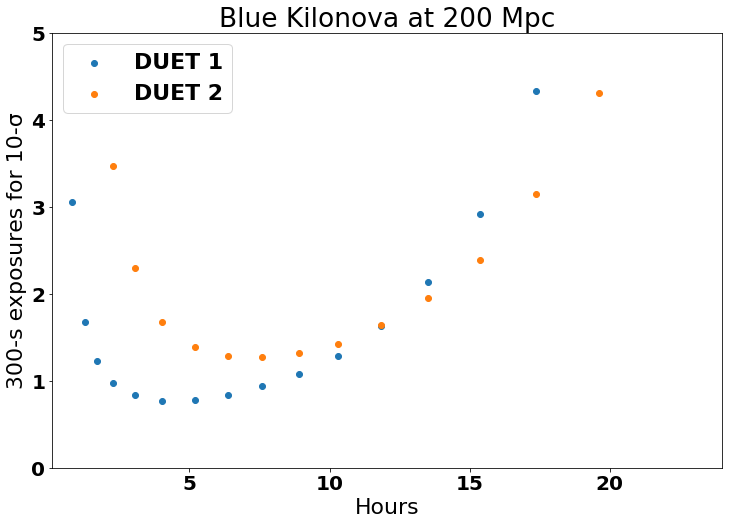

In [17]:
with quantity_support():
    plt.figure(figsize=[12, 8])
    plt.scatter(all_time.to(u.hr), all_exp1/300*u.s, label='DUET 1')
    plt.scatter(all_time.to(u.hr), all_exp2/300*u.s, label='DUET 2')
    plt.title('Blue Kilonova at 200 Mpc')

    plt.xlim([0.1, 24])
    plt.ylim([0, 5])
    plt.ylabel('300-s exposures for 10-σ')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

In [18]:
dist = 200*u.Mpc
ab_vega = 1.73

# Load Tony's lightcurves
shock = np.loadtxt('input_data/shock.dat')
blukn = np.loadtxt('input_data/kilonova_blue.dat')

config=11
diameter, qe, psf_size, pixel_size, efficiency = load_telescope_parameters(config)
area = 4 * np.pi * (diameter*0.5)**2

# Add in fuzz...
psf_size = (psf_size**2 + point_drift**2 + point_jitter**2)**0.5


print('Effective PSF size {}'.format(psf_size))
# Get the number of effective background pixels
neff = get_neff(psf_size, pixel_size)
print('Number of effective bgd pixels: {}'.format(neff))
print()

print('---------')


# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(diag=True,high_zodi=True,
                              diameter=diameter,
                              band=td1_band,
                              pixel_size=pixel_size, real_red=True,light=True)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))


bgd_ph_rate = bgd_sky_qe_rate(diag=True,high_zodi=True,
                              diameter=diameter,
                              band=td1_band,qe_band=2,
                              pixel_size=pixel_size, real_red=True,light=True)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))






# Do model at peak Swift UVOT luminosity
swiftmag = 0
all_exp1 = []
all_exp2 = []

all_time = shock[:, 1]*u.d
for row in shock:
    thismag = (row[14]+ab_vega)*u.ABmag
    swiftmag = thismag
    bbtemp = row[3]*u.K

    band1_fluence, band2_fluence = bb_abmag_fluence(dist = dist,
                                                    bbtemp = bbtemp,
                                                    swiftmag = swiftmag,
                                                    diag=False, light=True)

    band1_rate = trans_eff  * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence



    exposure1 = calc_exposure(siglimit, band1_rate, bgd_band1,read_noise, neff)
    exposure2 = calc_exposure(siglimit, band2_rate, bgd_band2,read_noise, neff)


#    print('{} {} {} {} {}'.format(peaktime, bbtemp, thismag, band1_rate, exposure))
    all_exp1 = np.append(all_exp1, exposure1)
    all_exp2 = np.append(all_exp2, exposure2)





Telescope Configuration 11
Name: Small Focal Plane CMOS
Entrance Pupil diameter 26.0 cm
Optical Efficiency 0.7893639053254439
PSF FWHM 4.288 arcsec
Pixel size 6.4 arcsec
Effective Aperture 23.1 cm
Effective Area 419.09631397051237 cm2
Effective PSF size 6.6623527375845235 arcsec
Number of effective bgd pixels: 2.990374488245114

---------
Optics reflectivity loader
Input file input_data/al_mgf2_mirror_coatings.csv
Detector Q.E. loader
Band 1 has input file input_data/detector_180_220nm.csv
Red filter loader
Band 1 has input file input_data/duet1_filter_light.csv
Background Computation Integrating over Pixel Area
Telescope diameter: 26.0 cm
Band: [193. 233.] nm
Bandpass: 40.0 nm


Pixel Area: 40.96000000000001 arcsec2

Background fluence per arcsec2 1.2401266033612891e-05 1 / (arcsec2 cm2 s)
Rate 0.26968857555040016 1 / s
Sky background rate per pixel band1: 0.1738508181556778 1 / s
Optics reflectivity loader
Input file input_data/al_mgf2_mirror_coatings.csv
Detector Q.E. loader
Band 2 

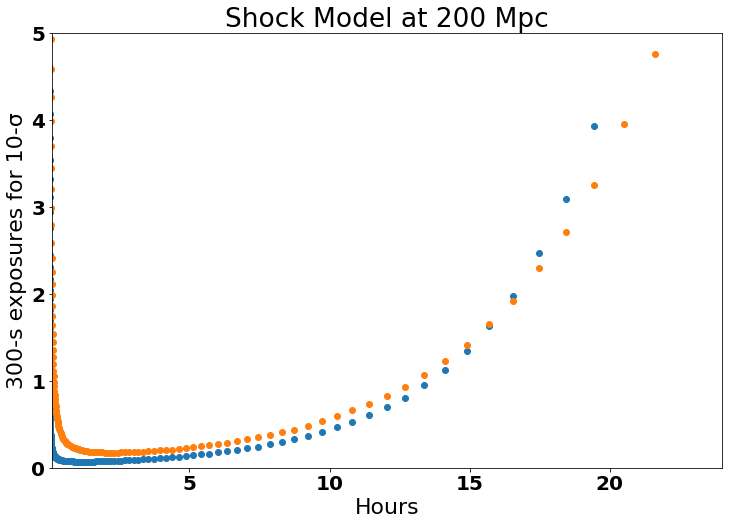

In [20]:
with quantity_support():
    plt.figure(figsize=[12, 8])
    plt.scatter(all_time.to(u.hr), all_exp1/300*u.s, label='DUET 1')
    plt.scatter(all_time.to(u.hr), all_exp2/300*u.s, label='DUET 2')
    plt.title('Shock Model at 200 Mpc')

    plt.ylim([0, 5])
    plt.xlim([0.1, 24])
    plt.ylabel('300-s exposures for 10-σ')
    plt.xlabel('Hours')
    
    plt.show()